# LDA in Python – How to grid search best topic models?

Python’s Scikit Learn provides a convenient interface for topic modeling using algorithms like Latent Dirichlet allocation(LDA), LSI and Non-Negative Matrix Factorization. In this notebook, I build the best possible LDA topic model and explore how to showcase the outputs as meaningful results.

Based on [Gensim Topic Modeling Visualization](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [16]:
import re, gensim, os, sys, spacy
import numpy as np
import pandas as pd

from gensim import models

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

print('Python Version: %s' % (sys.version))

Python Version: 2.7.15 | packaged by conda-forge | (default, Feb 28 2019, 04:00:11) 
[GCC 7.3.0]


In [6]:
dictionary = gensim.corpora.Dictionary.load('documents.dict')
corpus = gensim.corpora.MmCorpus('documents.mm')
lda_model = models.LdaModel.load('lda_model')
ldamallet = models.wrappers.LdaMallet.load('ldamallet')
optimal_model = models.wrappers.LdaMallet.load('optimal_model')

print(dictionary)
print(corpus)
print(lda_model)
print(ldamallet)

Dictionary(7714 unique tokens: [u'francesco', u'csuci', u'univesidad', u'sation', u'efimenko']...)
MmCorpus(4 documents, 7714 features, 10760 non-zero entries)
LdaModel(num_terms=7714, num_topics=20, decay=0.5, chunksize=100)


In [7]:
import pickle
#with open('documents', 'wb') as f: #save
#    pickle.dump(mylist, f)

with open('documents', 'rb') as f: #load
    documents = pickle.load(f)

## Tokenize and Clean-up using gensim’s simple_preprocess()
The sentences look better now, but you want to tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally I have set deacc=True to remove the punctuations.

In [185]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(documents))

## Lemmatization
Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

You can expect better topics to be generated in the end.

In [19]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(documents, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. In the below code, I have configured the `CountVectorizer` to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a 2D array format, call the 1todense()1 method of the sparse matrix like its done in the next step.

In [21]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=4,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [24]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

('Sparsicity: ', 100, '%')


## Build LDA model with sklearn
Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call `fit_transform()` to build the LDA model.

For this example, I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [26]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [27]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

('Log Likelihood: ', -132225.52642628262)
('Perplexity: ', 71.81012514882161)
{'learning_offset': 10.0, 'n_jobs': -1, 'topic_word_prior': None, 'perp_tol': 0.1, 'evaluate_every': -1, 'max_iter': 10, 'mean_change_tol': 0.001, 'batch_size': 128, 'max_doc_update_iter': 100, 'learning_decay': 0.7, 'n_components': 20, 'random_state': 100, 'doc_topic_prior': None, 'n_topics': None, 'total_samples': 1000000.0, 'learning_method': 'online', 'verbose': 0}


## How to GridSearch the best LDA model?
The most important tuning parameter for LDA models is `n_components` (number of topics). In addition, I am going to search `learning_decay` (which controls the learning rate) as well.

Besides these, other possible search params could be `learning_offset` (downweigh early iterations. Should be `> 1) and max_iter`. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [28]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_components': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## How to see the best topic model and its parameters?

In [29]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

("Best Model's Params: ", {'learning_decay': 0.7, 'n_components': 15})
('Best Log Likelihood Score: ', -63877.4293436688)
('Model Perplexity: ', 65.24115643748976)


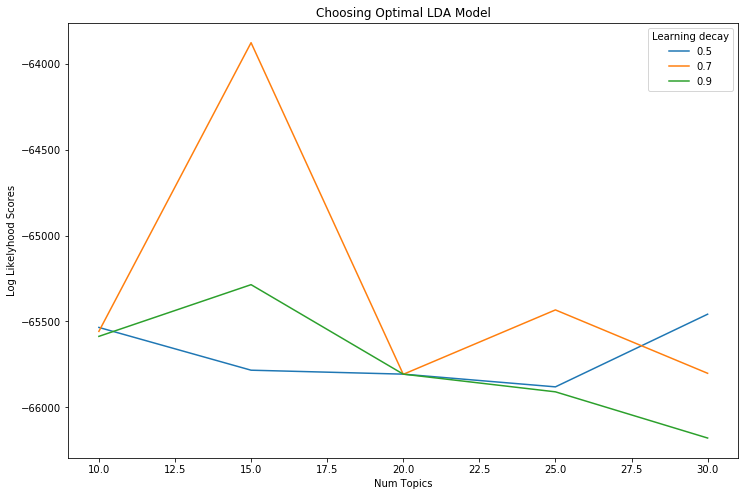

In [174]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = []
log_likelyhoods_7 = []
log_likelyhoods_9 = []

for i in range(len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.5:
       log_likelyhoods_5.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.7:
       log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.9:
       log_likelyhoods_9.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [177]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0,0,0,0,0,0,0,0.03,0,0.02,0,0,0,0.95,0,13
Doc1,0,0,0,0,0,0,0,0.87,0,0.04,0,0,0,0.09,0,7
Doc2,0,0,0,0,0,0,0,0.02,0,0.98,0,0,0,0,0,9
Doc3,0,0,0,0,0,0,0,0.24,0,0.05,0,0,0.71,0,0,12


## Review topics distribution across documents

In [178]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,1
1,13,1
2,12,1
3,9,1


## How to visualize the LDA model with pyLDAvis?
The pyLDAvis offers the best visualization to view the topics-keywords distribution.

In [179]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/storopoli/anaconda3/envs/textract/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
9      41.313846        1       1   92.823944  277.897736
13     29.465382        1       2   10.098292   73.152367
7      26.904161        1       3 -211.114838   71.768890
12      2.307132        1       4  300.266388  242.165680
14      0.000862        1       5  209.980164  -73.271851
11      0.000862        1       6 -103.026955  239.461899
10      0.000862        1       7  176.792694   92.916710
8       0.000862        1       8   70.803841 -369.880981
6       0.000862        1       9   71.499527 -167.576370
5       0.000862        1      10 -254.850174 -133.480774
4       0.000862        1      11  247.896393 -279.428040
3       0.000862        1      12  380.298859   51.699879
2       0.000862        1      13  397.368561 -148.765701
1       0.000862        1      14 -108.127785 -278.191223
0       0.000862        1      15  -69.975945  -74.179192, topic_info=    Category         Freq        Term        Total  loglift  logprob
26   Default  1742.000000       chang  1742.000000  30.0000  30.0000
62   Default  2814.000000        educ  2814.000000  29.0000  29.0000
110  Default  1649.000000       learn  1649.000000  28.0000  28.0000
182  Default   977.000000       teach   977.000000  27.0000  27.0000
102  Default  1015.000000    institut  1015.000000  26.0000  26.0000
92   Default   899.000000        high   899.000000  25.0000  25.0000
188  Default   736.000000      univer   736.000000  24.0000  24.0000
127  Default   658.000000         new   658.000000  23.0000  23.0000
49   Default   510.000000       datum   510.000000  22.0000  22.0000
93   Default   730.000000        http   730.000000  21.0000  21.0000
167  Default   463.000000      scienc   463.000000  20.0000  20.0000
139  Default   440.000000     practic   440.000000  19.0000  19.0000
53   Default   508.000000     develop   508.000000  18.0000  18.0000
131  Default   573.000000         org   573.000000  17.0000  17.0000
14   Default   417.000000        base   417.000000  16.0000  16.0000
183  Default   425.000000   technolog   425.000000  15.0000  15.0000
186  Default   391.000000       trend   391.000000  14.0000  14.0000
28   Default   343.000000   classroom   343.000000  13.0000  13.0000
195  Default   314.000000        work   314.000000  12.0000  12.0000
159  Default   370.000000      report   370.000000  11.0000  11.0000
101  Default   267.000000       innov   267.000000  10.0000  10.0000
98   Default   272.000000       indic   272.000000   9.0000   9.0000
181  Default   265.000000      survei   265.000000   8.0000   8.0000
11   Default   269.000000      assess   269.000000   7.0000   7.0000
100  Default   306.000000      inform   306.000000   6.0000   6.0000
160  Default   295.000000    research   295.000000   5.0000   5.0000
175  Default   257.000000       state   257.000000   4.0000   4.0000
43   Default   258.000000        cour   258.000000   3.0000   3.0000
178  Default   233.000000       studi   233.000000   2.0000   2.0000
27   Default   213.000000       class   213.000000   1.0000   1.0000
..       ...          ...         ...          ...      ...      ...
58   Topic15     0.001346    download    11.187104   2.6367  -5.2883
192  Topic15     0.001346      websit    11.239997   2.6320  -5.2883
116  Topic15     0.001346      london    12.190650   2.5508  -5.2883
194  Topic15     0.001346        word    12.241608   2.5466  -5.2883
39   Topic15     0.001346     convent    13.175268   2.4731  -5.2883
107  Topic15     0.001346     journal    13.274150   2.4656  -5.2883
105  Topic15     0.001346       inten    14.216962   2.3970  -5.2883
40   Topic15     0.001346     converg    15.153181   2.3332  -5.2883
115  Topic15     0.001346       local    15.234312   2.3279  -5.2883
88   Topic15     0.001346         gen    15.272985   2.3254  -5.2883
73   Topic15     0.001346       exten    15.342827   2.3208  -5.2883
140 

## How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in `lda_model.components_` as a 2d array. The names of the keywords itself can be obtained from vectorizer object using `get_feature_names()`.

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [180]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,academ,access,activ,actual,adopt,analyt,appli,applic,approach,area,...,univer,user,virtual,web,websit,week,word,work,world,www
Topic0,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic1,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic2,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic3,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic4,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


## Get the top 15 keywords each topic
From the above output, I want to see the top 15 keywords that are representative of the topic.

The `show_topics()` defined below creates that.

In [181]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 1,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 2,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 3,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 4,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 5,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 6,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 7,learn,educ,http,technolog,univer,high,www,develop,org,new,digit,com,onlin,access,challeng
Topic 8,programm,replac,fruit,control,press,exist,exten,correspond,power,default,predict,london,miss,sub,post
Topic 9,educ,chang,new,datum,scienc,practic,org,classroom,base,http,innov,indic,work,high,class


## How to predict the topics for a new piece of text?
Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.

For our case, the order of transformations is:

`sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()`

You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a `predict_topic()` function.

In [188]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)

## How to cluster documents that share similar topics and plot?
You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 4 clusters, I’ve set `n_clusters=4` `in KMeans()`.

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the `lda_output` object with `n_components` as 2. SVD ensures that these two columns captures the maximum possible amount of information from `lda_output` in the first 2 components.

In [190]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

("Component's weights: \n", array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.54,  0.  ,
         0.64,  0.  ,  0.  ,  0.21,  0.51,  0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.23, -0.  ,
         0.73, -0.  , -0.  , -0.03, -0.65, -0.  ]]))
('Perc of Variance Explained: \n', array([0.03, 0.42]))


We have the X, Y and the cluster number for each document.

Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

Text(0.5,1,'Segregation of Topic Clusters')

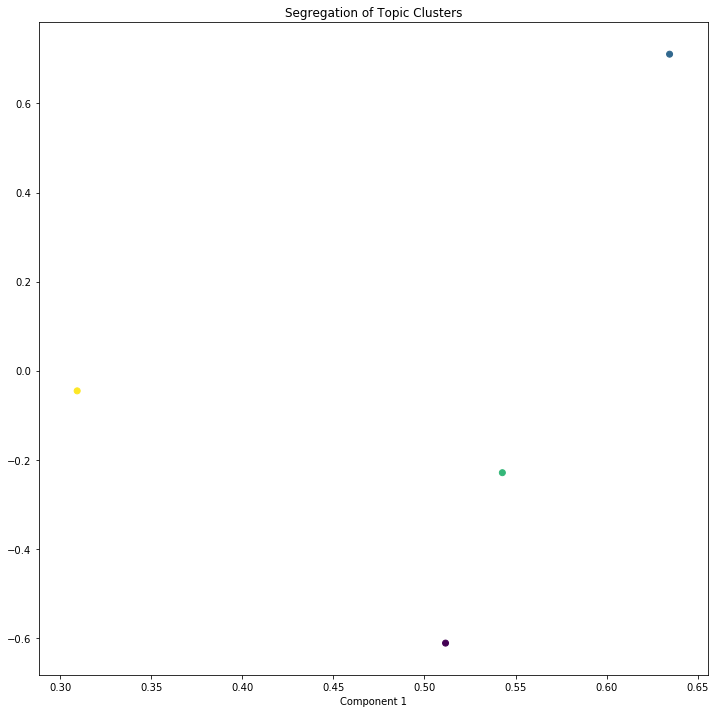

In [192]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters")

## How to get similar documents for any given piece of text?
Once you know the probaility of topics for a given document (using `predict_topic()`), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [194]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = documents, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [197]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = documents, top_n=1, verbose=True)
print('\n', docs[0][:10])

('Topic KeyWords: ', [u'programm', u'replac', u'fruit', u'control', u'press', u'exist', u'exten', u'correspond', u'power', u'default', u'predict', u'london', u'miss', u'sub', u'post'])
('Topic Prob Scores of text: ', array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1]]))
("Most Similar Doc's Probs:  ", array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.7,
        0. , 0. ]]))
('\n', [u'panorama', u'tecnol', u'gico', u'nmc', u'universidad', u'brasileira', u'uma', u'lise', u'region', u'horizon'])
